In [1]:
import scipy.io as io
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch
from torch.optim import lr_scheduler
from util.misc import AverageMeter

# datasets
from dataset.data_util import pil_load_img
from dataset.dataload import TextInstance, TextDataset
import torch.utils.data as data
from dataset.total_text import TotalText
from util.config import config as cfg, update_config, print_config

# models
from models import TextNet

# Losses
from loss import TextLoss

In [10]:
# 学習の設定
dataset = "total-text"
LoadWeights = False
WeightPath = "weights/hoge.pth"
original = True # 論文と同等のネットワークか
batch_size = cfg.batch_size

In [16]:
# Define model
model = TextNet(original=original)

# Cuda?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device=="cuda":
    cudnn.benchmark = True
model.to(device)

# Load weights if required
if LoadWeights:
    model.load_state_dict(torch.load(WeightPath)['model'])

In [12]:
# Data augumentationの設定。
"""
Images are randomly rotated, and cropped with areas ranging from 0.24 to 1.69
and aspect ratios ranging from 0.33 to 3. After that, noise, blur, and lightness
are randomly adjusted. We ensure that the text on the augmented images are
still legible, if they are legible before augmentation.

→ crop areaの設定を論文に忠実になるように変更
"""
from util.augmentation import BaseTransform, Augmentation
# 論文の通りrandom resize scale(0.24~1.69) aspect(0.33~3)、Mirror flip,, random rotation, 
# lighting noiseを付加

In [13]:
# Define dataset
# 最初にSynthTextで1 epoch学習し、その重みを元にTotalTextでFinetuneする。
if dataset == 'total-text':
    trainset = TotalText(
        data_root='data/total-text',
        ignore_list=None,
        is_training=True,
        transform=Augmentation(size=cfg.input_size, mean=cfg.means, std=cfg.stds)
    )

    valset = TotalText(
        data_root='data/total-text',
        ignore_list=None,
        is_training=False,
        transform=BaseTransform(size=cfg.input_size, mean=cfg.means, std=cfg.stds)
    )
elif dataset == 'synth-text':
    trainset = SynthText(
        data_root='data/SynthText',
        is_training=True,
        transform=Augmentation(size=cfg.input_size, mean=cfg.means, std=cfg.stds)
    )
    valset = None
else:
    raise NotImplementedError(dataset)
    
# Define loaders
train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
if dataset == "total-text":
    val_loader = torch.utils.data.DataLoader(valset,batch_size=batch_size)

可視化してaugumentationが上手く適応できているか確認

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


show imgs


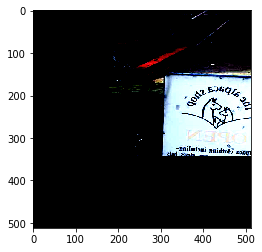

tcl_mask


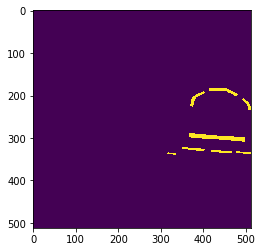

radius_map


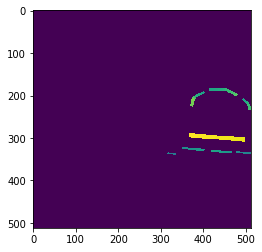

sin_map


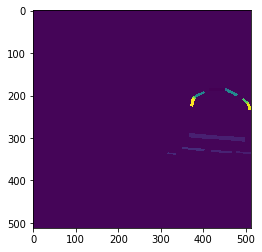

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


show imgs


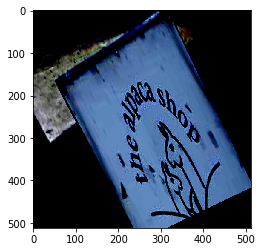

tcl_mask


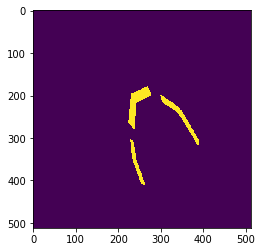

radius_map


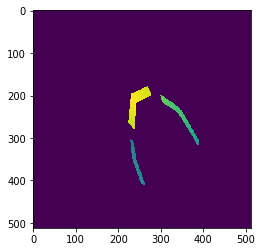

sin_map


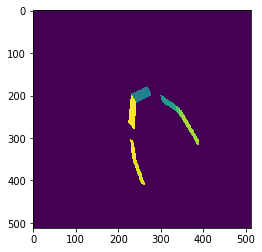

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


show imgs


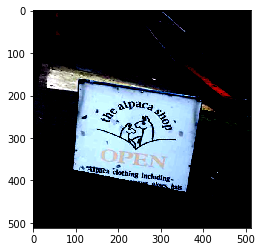

tcl_mask


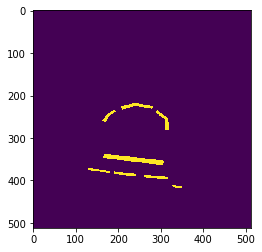

radius_map


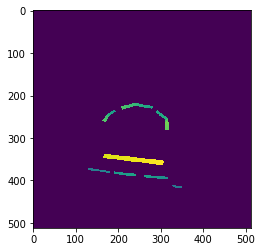

sin_map


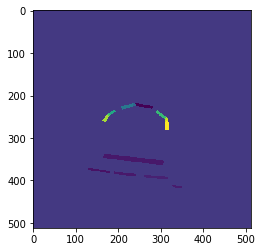

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


show imgs


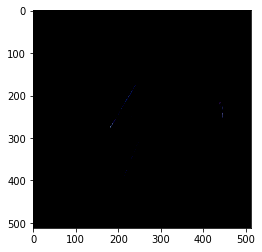

tcl_mask


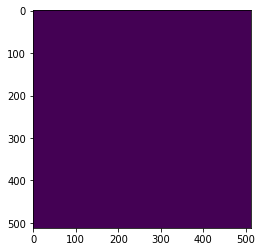

radius_map


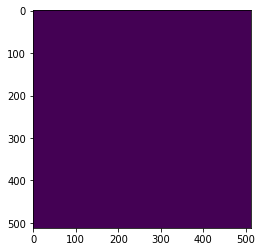

sin_map


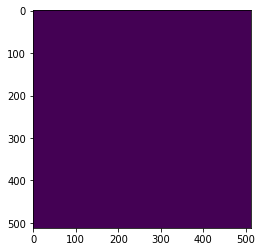

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


show imgs


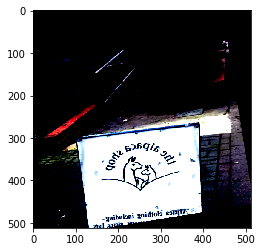

tcl_mask


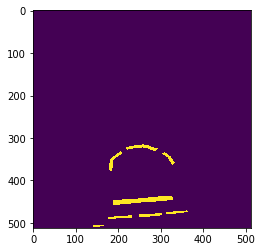

radius_map


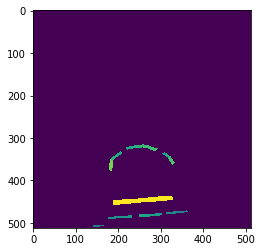

sin_map


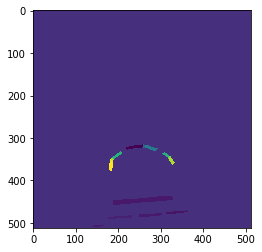

In [14]:
for i in range(5):
    # show some images
    image, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map, meta = trainset[0]
    print("show imgs")
    plt.imshow(image.transpose([1,2,0]))
    plt.show()
    print("tcl_mask")
    plt.imshow(tcl_mask)
    plt.show()
    print("radius_map")
    plt.imshow(radius_map)
    plt.show()
    print("sin_map")
    plt.imshow(sin_map)
    plt.show()

# Define Loss and optimizer

In [7]:
# コード解説はloss.pyに記載
criterion = TextLoss()

In [8]:
"""
We adopt the Adam optimazer [41] as our learning rate scheme. During the pre-training stage,
the learning rate is fixed to 10−3. During the fine-tuning stage, the learing rate is
set to 10−3 initially and decaies with a rate of 0.8 every 5000 iterations.
"""
# AdamとStepLRschedulerを使用。
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.8)

# Trainingを定義

In [18]:
# モデル保存の便利関数を流用
def save_model(model, epoch, lr, optimzer):
    save_dir = os.path.join(cfg.save_dir, cfg.exp_name)
    if not os.path.exists(save_dir):
        mkdirs(save_dir)

    save_path = os.path.join(save_dir, 'textsnake_{}_{}.pth'.format(model.backbone_name, epoch))
    print('Saving to {}.'.format(save_path))
    state_dict = {
        'lr': lr,
        'epoch': epoch,
        'model': model.state_dict() if not cfg.mgpu else model.module.state_dict(),
        'optimizer': optimzer.state_dict()
    }
    torch.save(state_dict, save_path)

In [19]:
def train(model, train_loader, criterion, scheduler, optimizer, epoch, logger):
    global train_step
    losses = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    end = time.time()
    model.train()
    scheduler.step()
    print('Epoch: {} : LR = {}'.format(epoch, lr))

    for i, (img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map, meta) in enumerate(train_loader):
        data_time.update(time.time() - end)

        train_step += 1
        # Cudaへ
        img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map = to_device(
            img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map)
        
        # 画像を入力しpredictionを元にロス計算
        output = model(img)
        tr_loss, tcl_loss, sin_loss, cos_loss, radii_loss = \
            criterion(output, tr_mask, tcl_mask, sin_map, cos_map, radius_map, train_mask)
        
        # 論文ではそれぞれのロスに重み付けをしていない
        # >The weights constants λ1, λ2, λ3, λ4 and λ5 are all set to 1 in our experiments.
        loss = tr_loss + tcl_loss + sin_loss + cos_loss + radii_loss

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # トラッカー更新。便利なのでそのまま使った。
        losses.update(loss.item())
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if cfg.viz and i % cfg.viz_freq == 0:
            visualize_network_output(output, tr_mask, tcl_mask, mode='train')

        if i % cfg.display_freq == 0:
            print('({:d} / {:d}) - Loss: {:.4f} - tr_loss: {:.4f} - tcl_loss: {:.4f} - sin_loss: {:.4f} - cos_loss: {:.4f} - radii_loss: {:.4f}'.format(
                i, len(train_loader), loss.item(), tr_loss.item(), tcl_loss.item(), sin_loss.item(), cos_loss.item(), radii_loss.item())
            )

        if i % cfg.log_freq == 0:
            logger.write_scalars({
                'loss': loss.item(),
                'tr_loss': tr_loss.item(),
                'tcl_loss': tcl_loss.item(),
                'sin_loss': sin_loss.item(),
                'cos_loss': cos_loss.item(),
                'radii_loss': radii_loss.item()
            }, tag='train', n_iter=train_step)

    if epoch % cfg.save_freq == 0:
        save_model(model, epoch, scheduler.get_lr(), optimizer)

    print('Training Loss: {}'.format(losses.avg))

# Validationを定義。ほぼtrainと同様。

In [21]:
def validation(model, valid_loader, criterion, epoch, logger):
    # gradを計算しないことでメモリ節約、高速化
    with torch.no_grad():
        model.eval()
        losses = AverageMeter()
        tr_losses = AverageMeter()
        tcl_losses = AverageMeter()
        sin_losses = AverageMeter()
        cos_losses = AverageMeter()
        radii_losses = AverageMeter()

        for i, (img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map, meta) in enumerate(valid_loader):

            img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map = to_device(
                img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map)

            output = model(img)

            tr_loss, tcl_loss, sin_loss, cos_loss, radii_loss = \
                criterion(output, tr_mask, tcl_mask, sin_map, cos_map, radius_map, train_mask)
            loss = tr_loss + tcl_loss + sin_loss + cos_loss + radii_loss

            # update losses
            losses.update(loss.item())
            tr_losses.update(tr_loss.item())
            tcl_losses.update(tcl_loss.item())
            sin_losses.update(sin_loss.item())
            cos_losses.update(cos_loss.item())
            radii_losses.update(radii_loss.item())

            if cfg.viz and i % cfg.viz_freq == 0:
                visualize_network_output(output, tr_mask, tcl_mask, mode='val')

            if i % cfg.display_freq == 0:
                print(
                    'Validation: - Loss: {:.4f} - tr_loss: {:.4f} - tcl_loss: {:.4f} - sin_loss: {:.4f} - cos_loss: {:.4f} - radii_loss: {:.4f}'.format(
                        loss.item(), tr_loss.item(), tcl_loss.item(), sin_loss.item(),
                        cos_loss.item(), radii_loss.item())
                )

        logger.write_scalars({
            'loss': losses.avg,
            'tr_loss': tr_losses.avg,
            'tcl_loss': tcl_losses.avg,
            'sin_loss': sin_losses.avg,
            'cos_loss': cos_losses.avg,
            'radii_loss': radii_losses.avg
        }, tag='val', n_iter=epoch)

        print('Validation Loss: {}'.format(losses.avg))


# 学習ループ開始

In [ ]:
print('Start training TextSnake.')
import gc
for epoch in range(cfg.start_epoch, cfg.max_epoch):
    train(model, train_loader, criterion, scheduler, optimizer, epoch, logger)
    if valset:
        validation(model, val_loader, criterion, epoch, logger)
    # ループ後にメモリ解放
    torch.cuda.empty_cache()
    gc.collect()